# PIACE Machine Learning Models & Data Analysis

This Jupyter Notebook contains code required to reproduce all data analyses performed.  In order to run this notebook make sure the required CSV files are pointed to in the code block below.

In [7]:
%matplotlib inline
import sys
sys.path.insert(0, '../')

DEBUG = False

import csv
import scipy
import math
from math import log
import pandas as pd
import numpy as np
import random

import seaborn
#seaborn.set_style("whitegrid")

#Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import font_manager as fm

matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.size'] = 9


#Scipy imports
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import curve_fit
from IPython.display import display

#Import Plotting Tools
from metabolicModelingTools import plotModel,generateReport

#Import Scikit learn functions
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score,cross_val_predict, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

#Import Models
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LassoLarsIC
from sklearn.gaussian_process import GaussianProcessRegressor

In [8]:
data_file = 'PIACE.csv'
fig_file =  'PIACE_Fig1.csv'
copy_plot_file = 'PIACECopyNumberPlot.csv'
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [9]:
# Import CSV file downloaded from EDD and process it into correct format.
f = open(data_file)
raw_data = [ row  for i,row in enumerate(csv.reader(f)) if i > 0] 
X = [[float(value) for value in line[1:4]] for line in raw_data[:-1]]
Y = [[float(value) for value in line[4:7]] for line in raw_data[:-1]]
Z = [float(line[7]) for line in raw_data[:-1]]

df = pd.read_csv(data_file)

if DEBUG:
    print('Num Data Points: ', len(X))

df = df[:15]
df

fig1_df = pd.read_csv(fig_file)
display(df)

,"Spatial Co-ordinates (Gent, Cm, Spec)",Gentamycin(ug/mL),Chloremphenicol(ug/mL),Spectinomycin(ug/mL),Copy Number (Mevtop_Gent),Copy Number (PMK-MK_Cm),Copy Number (NudB_PMD_Spec),Isopentenol (mg/L),Isopentenol StdEv,Sum
0,1/1/01,12.5,15,25,1.100000,1.050000,1.182000,17.099559,3.784575,3.0
1,1/5/01,12.5,240,25,1.110000,6.134407,1.367333,18.505021,10.958727,7.0
2,5/1/01,200.0,15,25,3.940000,1.282467,1.615000,24.275215,4.939087,7.0
3,1/1/05,12.5,15,400,1.230000,1.562667,5.621400,16.610106,10.215280,7.0
4,1/5/05,12.5,240,400,1.486667,5.563850,7.210233,15.258444,2.409712,11.0
5,5/1/05,200.0,15,400,4.529700,1.566667,7.722000,27.070046,6.908177,11.0
6,5/5/01,200.0,240,25,5.476000,7.460267,1.721667,34.485734,3.742508,11.0
7,5/5/05,200.0,240,400,4.846000,8.217170,8.372000,105.405452,23.254119,15.0
8,3/3/03,50.0,60,100,4.062933,5.983533,5.606333,53.508468,10.980573,9.0
9,3/4/05,50.0,120,400,4.085000,7.026933,6.919800,47.212207,7.579647,12.0


## Visualize the Data Set.

### Figure 1: RFP/GFP qPCR/Flourescence plots
Below we construct Figure 1 containing copy number and flourescence data for RFP and GFP.

['RFP Fluorescence' 'GFP Fluorescence' 'RFP qPCR' 'GFP qPCR']


/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


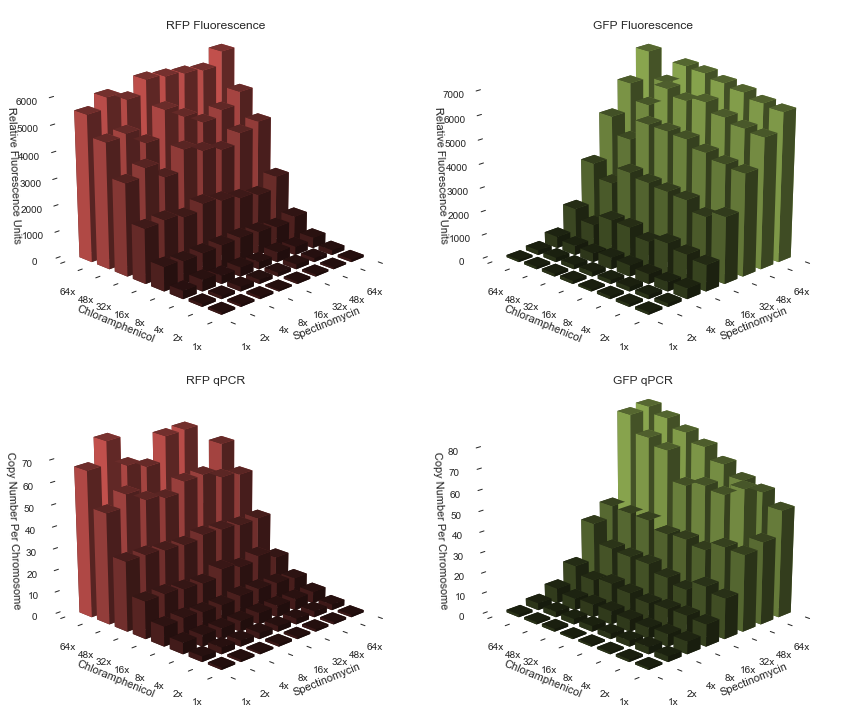

In [10]:
#Make 1 Plot for each measurement type
measurement_types = fig1_df['Measurement'].unique()
print(measurement_types)
def color_range(max_val,min_val,mask=(1,1,1)):
    
    def cmap(val):     
        scaled_val = (val - min_val)/(max_val - min_val)*0.7 + 0.3
        color = [m*scaled_val for m in mask]
        return tuple(color)
        
    return cmap

fig = plt.figure(figsize=(12,10))
for i,measurement_type in enumerate(measurement_types):
    ax = fig.add_subplot(int('22'+str(i+1)), projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the spines
    #ax.w_xaxis.grid.set_color((1.0, 1.0, 1.0, 1.0))
    #ax.w_yaxis.grid.set_color((1.0, 1.0, 1.0, 0.0))
    #ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.set_axis_bgcolor('white')
    
    xpos,ypos = np.meshgrid(np.arange(1,9),np.arange(1,9))
    xpos = np.ravel(xpos).tolist()
    ypos = np.ravel(ypos).tolist()
    n_bars = len(xpos)
    zpos = [0]*n_bars
    dx = np.ones(n_bars)*0.7
    dy = np.ones(n_bars)*0.7
    dz = fig1_df['Value'].loc[fig1_df['Measurement']==measurement_type].values
    
    if measurement_type in ['RFP Fluorescence','RFP qPCR']:
        mask = (193/255,80/255,76/255)
    elif measurement_type in ['GFP Fluorescence','GFP qPCR']:
        mask = (137/255,165/255,78/255)
        
    cmap = color_range(max(dz),min(dz),mask=mask)
    colors = [cmap(val) for val in dz]
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)    
    
    
    plt.ylabel('Chloramphenicol',fontname = 'Arial')
    plt.xlabel('Spectinomycin',fontname = 'Arial')
    plt.title(measurement_type,fontname = 'Arial')
    if measurement_type in ['RFP Fluorescence','GFP Fluorescence']:
        ax.set_zlabel('Relative Fluorescence Units',fontname = 'Arial')
    else:
        ax.set_zlabel('Copy Number Per Chromosome',fontname = 'Arial')
    
    #Change Labels
    #xlabels = [item.get_text() for item in ax.get_xticklabels()]
    #ylabels = [item.get_text() for item in ax.get_yticklabels()]
    
    labels = ['1x','2x','4x','8x','16x','32x','48x','64x','']
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels)
    ax.xaxis._axinfo['label']['space_factor'] = 2.8
    ax.view_init(25, 225)

plt.tight_layout()
plt.savefig('fig1.pdf')
plt.show()

### Figure 2: Copy Number vs. Isopentenol Production

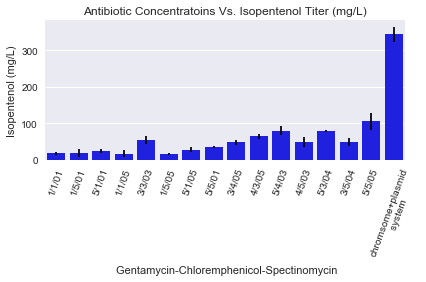

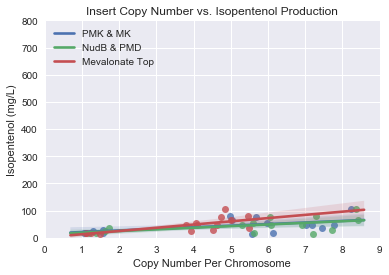

In [11]:
#Add plasmid data
#df_plot = df.sort(columns="Isopentenol (mg/L)")
df_plot = df.copy()
df_plot = df_plot.sort_values('Sum',ascending=True)

df_plot.loc[-1] = ['chromsome+plasmid\n system','','','','','','', 343.7,20.80061252,20]
seaborn.barplot("Spatial Co-ordinates (Gent, Cm, Spec)", y="Isopentenol (mg/L)",data=df_plot,color='b',capsize=.2)
plt.errorbar([i for i in range(len(df_plot['Isopentenol StdEv'].values))],
             df_plot['Isopentenol (mg/L)'].values,
             yerr=df_plot['Isopentenol StdEv'].values,
             fmt=' ',color='k',capthick=1)
plt.ylabel('Isopentenol (mg/L)')
plt.xlabel(' Gentamycin-Chloremphenicol-Spectinomycin')
plt.title('Antibiotic Concentratoins Vs. Isopentenol Titer (mg/L)')
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('fig2a.pdf')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
seaborn.regplot('Copy Number (PMK-MK_Cm)','Isopentenol (mg/L)',data=df,ax=ax)
seaborn.regplot('Copy Number (NudB_PMD_Spec)','Isopentenol (mg/L)',data=df,ax=ax)
seaborn.regplot('Copy Number (Mevtop_Gent)','Isopentenol (mg/L)',data=df,ax=ax)
ax.set_xlabel('Copy Number Per Chromosome')
plt.title('Insert Copy Number vs. Isopentenol Production')
plt.legend(['PMK & MK','NudB & PMD','Mevalonate Top'],loc='upper left')
plt.ylim(0, 800)
plt.xlim(0,9)
plt.savefig('fig2b.pdf')
plt.show()

Here we plot the data set along each copy number axis and can clearly see that a general trend of increasing the copy number of any insert consistently increases isopentenol titer. On the Right we can visualize the three dimensional scatter plot of all of the data to see how it is distributed.

/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  
/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


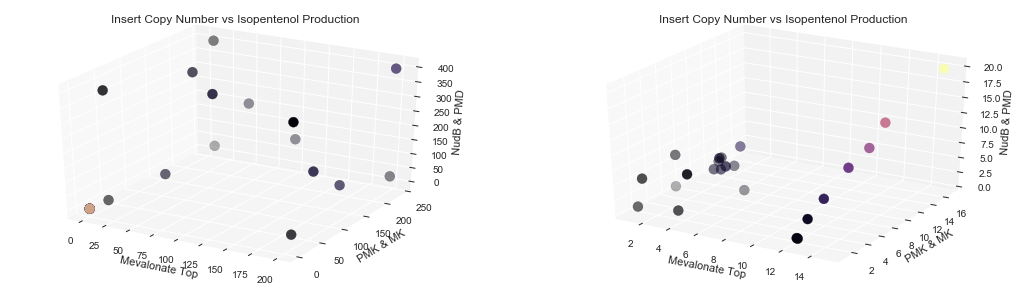

In [12]:
x = [value[0] for value in X]
y = [value[1] for value in X]
z = [value[2] for value in X]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
ax2 = fig.add_subplot(121, projection='3d')
ax2.scatter(x,y,z,c=Z,cmap=plt.get_cmap('inferno'),s=100)
ax2.set_xlabel('Mevalonate Top')
ax2.set_ylabel('PMK & MK')
ax2.set_zlabel('NudB & PMD')
plt.title('Insert Copy Number vs Isopentenol Production')
ax2.set_axis_bgcolor('white')


x = [value[0] for value in Y]
y = [value[1] for value in Y]
z = [value[2] for value in Y]

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(x,y,z,c=Z,cmap=plt.get_cmap('inferno'),s=100)
ax1.set_xlabel('Mevalonate Top')
ax1.set_ylabel('PMK & MK')
ax1.set_zlabel('NudB & PMD')
plt.title('Insert Copy Number vs Isopentenol Production')
ax1.set_axis_bgcolor('white')
plt.show()

### Antibiotic Concentration to Copy Number Relationship

First to get a sense of the data we are going to visualize the relationship between the copy number found and the antibiotic concentration given to the culture for each construct.  In the plot below we show that it fits well to a logarithmic curve. We can use this later on to predict the copy numbers for the untested strains.

/Users/zakcostello/anaconda/lib/python3.6/site-packages/seaborn/linearmodels.py:267: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


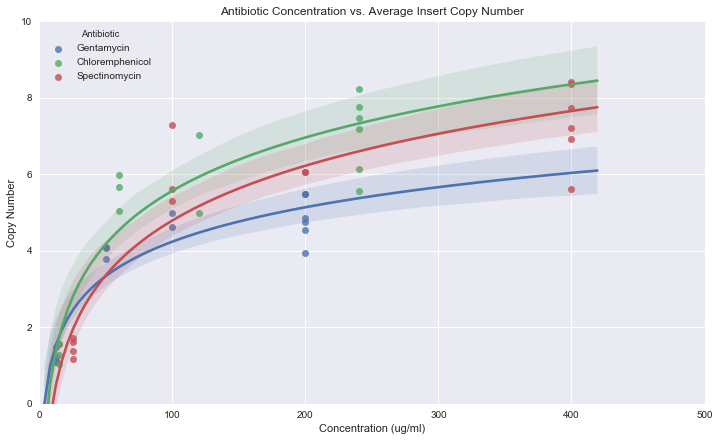

In [14]:
data = pd.read_csv(copy_plot_file)
      
#for i in range(3):
#    x = np.array([line[i] for line in X])
#    y = np.array([line[i] for line in Y])
#    seaborn.regplot(x=x,y=y,logx=True,scatter=True)
#    plt.show()

seaborn.lmplot(x='Concentration (ug/ml)',
               y='Copy Number',
               data=data,hue='Antibiotic',
               logx=True,legend_out=False,
               aspect=1.66,size=6)
plt.ylim(0, 10)
plt.xlim(0,500)
plt.title('Antibiotic Concentration vs. Average Insert Copy Number')
plt.show()

## Machine Learning Methods

Three regressor models were applied to predicting isopentenol titer from the number of genomically inserted copies of three different operons containing sections of the mevalonate pathway. 15 strains with varying copy numbers for each operon were provided along with measured isopentenol titers as a training set.  These copy numbers ranged from 1 to 9 and were verified by qPCR.  Polynomial, random forrest, and support vector regressors were applied to the training set. All regressors were implemented in python using scikit learn [1] and a jupyter notebook is provided as in supplementary file 1 where the analyses can be completely reproduced. Each model was evaluated using 10 fold cross validation and calculating the log error residuals of the resulting predicitons. The best performing model, the polynomial regressor, is plotted and evaluated in figure 5. The remaining   

[1] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}






In [33]:
#Import Data For Machine Learning
complete_df = pd.read_csv('./PIACE_COMPLETE.csv')
display(complete_df)
print(complete_df.columns)
Y = complete_df[['Copy Number (Mevtop_Gent)', 'Copy Number (PMK-MK_Cm)',
       'Copy Number (NudB_PMD_Spec)']].values
Z = complete_df['Isopentenol'].values

,CM,SP,Copy Number (Mevtop_Gent),Copy Number (PMK-MK_Cm),Copy Number (NudB_PMD_Spec),Isopentenol
0,1X,1X,12.492600,1.120000,1.430000,34.711563
1,2X,1X,12.492600,1.010000,2.050000,25.355000
2,4X,1X,12.492600,2.210000,2.910000,40.456000
3,8X,1X,12.492600,3.450000,3.720000,29.875434
4,16X,1X,12.492600,4.920000,3.290000,90.453000
5,32X,1X,12.492600,5.150000,5.810000,54.466000
6,64X,1X,12.492600,5.360000,6.170000,42.343500
7,1X,2X,12.492600,1.290000,1.050000,15.353500
8,2X,2X,12.492600,1.820000,0.980000,38.266374
9,4X,2X,12.492600,2.420000,1.190000,32.354560


Index(['CM', 'SP', 'Copy Number (Mevtop_Gent)', 'Copy Number (PMK-MK_Cm)',
       'Copy Number (NudB_PMD_Spec)', 'Isopentenol'],
      dtype='object')


In [34]:
# Define Model Cross Validation Method and Scoring Metrics
score = 'r2' #Use R^2 as model scoring metric
cv=10        #ShuffleSplit(n_splits=15) 

In [35]:
# Define all Models to Test
polynomialRegressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(),cv=cv, scoring=score)),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=None))])

supportVectorRegressor = Pipeline([('Scaler',StandardScaler()),
                                   ('SVR',SVR(kernel='sigmoid',C=0.5))])


models = {'Support Vector Regressor':supportVectorRegressor,
          'Random Forest Regressor':RandomForestRegressor(),
          'Polynomial Regressor':polynomialRegressor,
         }

In [36]:
#Optimize the Hyperparameters of the Models that need it... (SVR,Polynomial Model)

#Define the Dictionaries of Parameters to optimize for each model...
parameter_dists = {}
parameter_dists['Support Vector Regressor'] = {'SVR__C': scipy.stats.expon(scale=10),
                                               'SVR__gamma': scipy.stats.expon(scale=.1),
                                               'SVR__kernel': ['rbf','sigmoid','poly']}


#Hyperparamter optimize the Models with defined parameter distributions
for model in parameter_dists:
    models[model] = RandomizedSearchCV(models[model],
                                       parameter_dists[model], 
                                       n_iter=25, 
                                       scoring=score, 
                                       fit_params=None,
                                       cv=cv).fit(Y,Z)

In [37]:
for model in models:
    cross_validation = cross_val_score(models[model],Y,y=Z,cv=cv,scoring=score )
    #print(cross_validation)
    #print(model,sum(cross_validation)/len(cross_validation))

In [38]:
#Fit The Models
for model in models:
    models[model].fit(Y,Z)

Below we plot the fits of the data set to different machine learning models.  Each model is then evaluated by predicting all of the points in the training set.  Additionally, cross validation techniques are used to test how well the model will be able to predict the production of new strains. Below we plot how well the predictions match up between the test data and each model.

In [39]:
#Calculate Principal Components 
pca = PCA(n_components=2)
data_transformed = pca.fit(Y)

#Print Principal Components and Explained Variance
for num,component,explained_variance,explained_variance_ratio in zip([1,2],pca.components_,pca.explained_variance_,pca.explained_variance_ratio_):
    print('Principal Component',num,':',component,',',explained_variance,',',explained_variance_ratio)
    

Principal Component 1 : [ 0.39825457  0.65055481  0.646662  ] , 22.1035738415 , 0.599113237387
Principal Component 2 : [-0.91724467  0.27671711  0.28651326] , 13.3757832509 , 0.362548104823


Support Vector Regressor , Standard Deviation: 92.0939248468 Mean: 14.5869659448
Random Forest Regressor , Standard Deviation: 58.3432273054 Mean: 0.979612595062
[0.15860670253212772, 0.423221556923428, 0.41817174054444434]
Polynomial Regressor , Standard Deviation: 33.7649860215 Mean: -4.67796583048


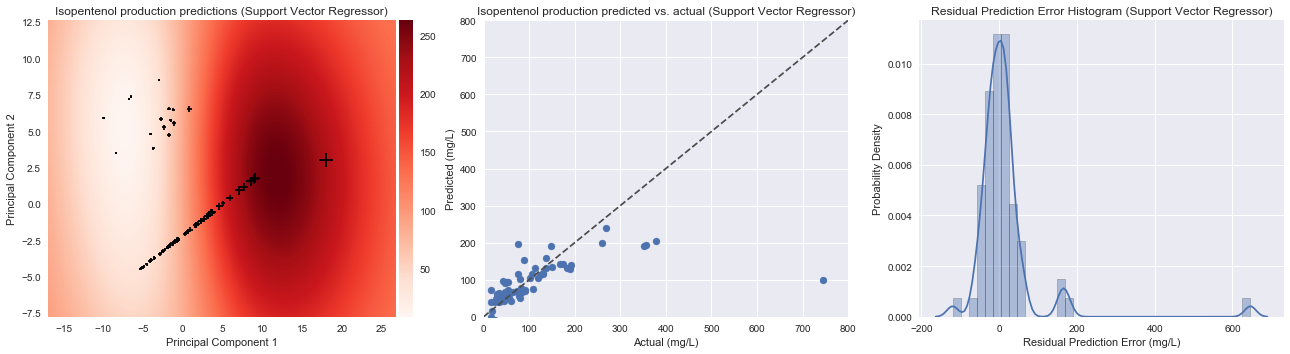

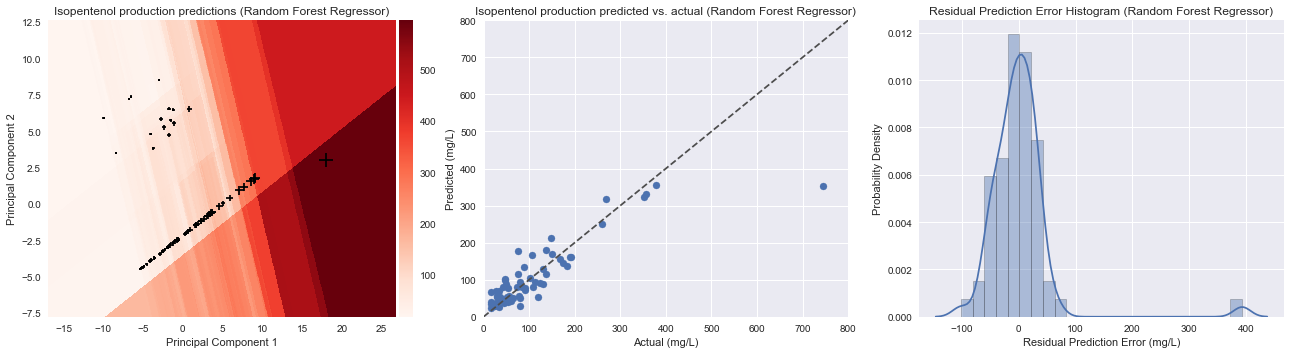

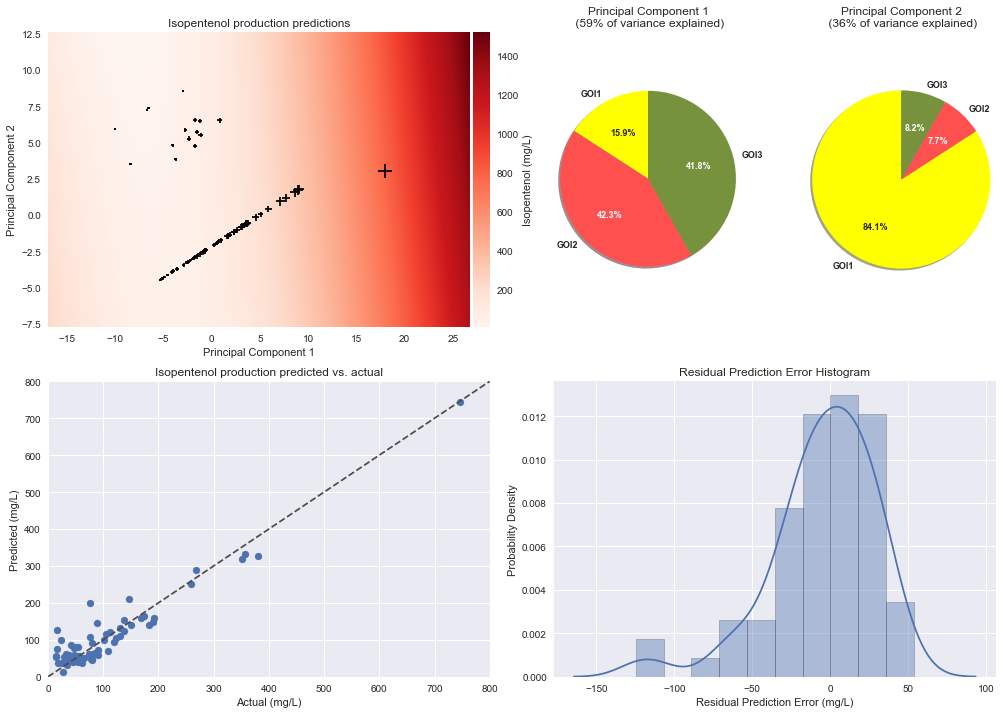

In [40]:
def residual_histagram(y_actual,y_predicted,log=False):
    if log:
        error = [math.log(max(y_a,0.01)) - math.log(max(y_p,0.01)) for y_a,y_p in zip(y_actual,y_predicted)]
    else:
        error = [y_a - y_p for y_a,y_p in zip(y_actual,y_predicted)]
    seaborn.distplot(error,hist_kws=dict(edgecolor="k", linewidth=0.5))

def print_metrics(y_actual,y_predicted,name=''):
    #error = [math.log(max(y_a,0.01)) - math.log(max(y_p,0.01)) for y_a,y_p in zip(y_actual,y_predicted)]
    error = [y_a - y_p for y_a,y_p in zip(y_actual,y_predicted)]
    print(name,', Standard Deviation:',np.std(error),'Mean:',np.mean(error))

#Principal Component Explained Variances
pc1_exp_var = int(pca.explained_variance_ratio_[0]*100)
pc2_exp_var = int(pca.explained_variance_ratio_[1]*100)

for i,model in enumerate(models):
    
    #Main Paper Figure
    if model == 'Polynomial Regressor':
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(14)
        
        
        #Fig 5A (Plot of Machine Learning Model)
        #ax = fig.add_subplot(2,2,1)
        ax = plt.subplot2grid((2,4),(0,0),colspan=2)
        plotModel(models[model],Y,Z,zlabel='Isopentenol (mg/L)',title=model + ' Predictions vs Pathway Insert Copy Numbers',ax=ax)
        ax.set_title('Isopentenol production predictions')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        
        #plt.tight_layout()        
        
        #Fig 5B (Pie Charts of Principal Components)
        labels = 'GOI1','GOI2','GOI3'
        colors = [(255/255,  255/255,  0/255), 
                  (255/255, 80/255,  80/255), 
                  (118/255 , 146/255, 60/255)]
        #ax = fig.add_subplot(2,2,2)
        ax = plt.subplot2grid((2,4),(0,2))
        pca_sq = [val**2 for val in pca.components_[0]]
        sizes = [c/sum(pca_sq) for c in pca_sq]
        print(sizes)
        _,texts,autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90,colors=colors,labeldistance=1.1)
        for i,autotext in enumerate(autotexts):
            if i != 0:
                autotext.set_color('white')
            
        plt.tight_layout()
        proptease = fm.FontProperties()
        proptease.set_weight('bold')
        plt.setp(autotexts, fontproperties=proptease)
        plt.setp(texts, fontproperties=proptease)
        
        ax.set_title('Principal Component 1\n (' + str(pc1_exp_var) + '% of variance explained)')
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        
        ax = plt.subplot2grid((2,4),(0,3))
        pca_sq = [val**2 for val in pca.components_[1]]
        sizes = [c/sum(pca_sq) for c in pca_sq]
        _,texts,autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90,colors=colors,labeldistance=1.1)
        for i,autotext in enumerate(autotexts):
            if i != 0:
                autotext.set_color('white')
        
        #plt.tight_layout()
        plt.gcf().subplots_adjust(right=0.9)
        
        proptease = fm.FontProperties()
        proptease.set_weight('bold')
        plt.setp(autotexts, fontproperties=proptease)
        plt.setp(texts, fontproperties=proptease)
        
        ax.set_title('Principal Component 2\n (' + str(pc2_exp_var) + '% of variance explained)')
        ax.axis('equal')
        
        #Fig 5C 
        #ax = fig.add_subplot(2,2,3)
        ax = plt.subplot2grid((2,4),(1,0),colspan=2)
        y_predict = cross_val_predict(models[model],Y,y=Z,cv=10)
        ax.scatter(Z,y_predict)
        ax.plot([0,800], [0,800], ls="--", c=".3")
        plt.ylim(0, 800)
        plt.xlim(0,800)
        plt.title('Isopentenol production predicted vs. actual' )
        plt.xlabel('Actual (mg/L)')
        plt.ylabel('Predicted (mg/L)')
        plt.tight_layout()       
        
        #Fig 5D
        #ax = fig.add_subplot(2,2,4)
        ax = plt.subplot2grid((2,4),(1,2),colspan=2)
        residual_histagram(Z,y_predict,log=False)
        plt.title('Residual Prediction Error Histogram')
        plt.xlabel('Residual Prediction Error (mg/L)')
        plt.ylabel('Probability Density')
        #plt.xlim(-3,3)
        
        plt.tight_layout()
        plt.savefig(model+'MachineLearningPlotMatrix.pdf')
        
        print_metrics(Z,y_predict,name=model)

    else:
        #Supplementary Figure 3
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(18)

        #Plot the Model
        ax = fig.add_subplot(1,3,1)
        plotModel(models[model],Y,Z,title='Isopentenol production predictions ('+model+')',ax=ax)
        #ax.set_xlabel('Principal Component 1 (' + str(pc1_exp_var) + '% of variance explained)')
        #ax.set_ylabel('Principal Component 2 (' + str(pc2_exp_var) + '% of variance explained)')
        
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        
        plt.tight_layout()

        #Cross Validation Scatter Plot
        ax1 = fig.add_subplot(1,3,2)
        y_predict = cross_val_predict(models[model],Y,y=Z,cv=10)
        ax1.scatter(Z,y_predict)
        ax = plt.gca()
        ax.plot([0,800], [0,800], ls="--", c=".3")
        plt.ylim(0, 800)
        plt.xlim(0,800)
        plt.title('Isopentenol production predicted vs. actual (' + model + ')' )
        plt.xlabel('Actual (mg/L)')
        plt.ylabel('Predicted (mg/L)')
        plt.tight_layout()

        #Error Residual Histagram
        ax2 = fig.add_subplot(1,3,3)
        residual_histagram(Z,y_predict,log=False)
        plt.title('Residual Prediction Error Histogram (' + model + ')')
        plt.xlabel('Residual Prediction Error (mg/L)')
        plt.ylabel('Probability Density')
        #plt.xlim(-3,3)

        #Calculate Metrics 
        print_metrics(Z,y_predict,name=model)
    
        plt.savefig(model+'MachineLearningPlotMatrix.pdf')

Three machine learning models were trained and cross validated to learn isopentenol production from integrated isopentenol pathway copy numbers.  These models were a support vector regressor, a polynomial regressor and a random forest regressor. The fits can be visualized in the first column. A darker red indicates a higher isopentenol titer.  The models show qualitative agreement despite differences in structure. The cross validated error is shown in column two where the actual and predicted isopentenol titers are compared. These points are found using 10 fold cross validation. The third column shows the log normal error residuals of each set of model predictions. While they are all quite close in performance, The polynomial regressor edges out both the random forest and support vector regressors with error standard deviations of 0.457, 0.592, and 0.536 respectively. This corresponds to all measurements within one standard deviation approximately having less than 50% error from their actual measured value.

In order to see how well different models will extrapolate, we left one data point which is far outside the convex hull of the data to test our models on.  The copy numbers are $[14.45,11.348,12.1]$.  This construct is able to produce 343.7 mg/L of isopentenol. Below we can see how closely each model would have come to predicting these results. Both the support vector regressor and gaussian process regressor perform very poorly as they tend to favor local descriptions of the data and are not typically good at extrapolation.  The polynomial regressor and linear regressor both report a substantial increase in production over the maximum isopentenol titer observed in the training set (105.4 mg/L). Finally, the random forest regressor does reasonably well by predicting that production will be in the high end of the range it observes.

In [29]:
#Predict for each model what the plasmid verion will produce...
y = [14.45,11.348,12.1]
z = (343.6943167,)

d = {'Measured Isopentenol Titer (mg/L)':pd.Series([343.6943167]),
     'Insert Copy Numbers':pd.Series([y])}


#print('Isopentenol Plasmid Test Strain')
#print('Actual',z[0])
for model in models:
    d[model] = pd.Series(models[model].predict([y]))
    #print(model,models[model].predict([y])[0])
    

pd.DataFrame(d)[['Insert Copy Numbers',]+[model for model in models] +['Measured Isopentenol Titer (mg/L)',]]
#pd.DataFrame(d)[['Insert Copy Numbers',]+['Polynomial Regressor'] +['Measured Isopentenol Titer (mg/L)',]]

,Insert Copy Numbers,Support Vector Regressor,Random Forest Regressor,Polynomial Regressor,Measured Isopentenol Titer (mg/L)
0,"[14.45, 11.348, 12.1]",197.095348,308.094017,311.541321,343.694317


## Predict the Production of other Untested Strains and decide on the best ones to test.

The antibiotic concenteration to insert copy number relationship is fit using a logarithmic curve for each antibiotic insert pair. Every untested strain's performance is tested by the model. Each model selects its best performing points which are agrigated in the list below in no particular order.

In [30]:
# fit The data to curves for each different antibiotic and copy number pair
def logfit(x,a,b):
    return [a + b*log(val) for val in x] 

best_params = []
for i in range(3):
    x = [line[i] for line in X]
    y = [line[i] for line in Y]
    best_params.append(curve_fit(logfit,x,y)[0])
    
# find all untested strains
def antibioticConcentration(strain):
    return (12.5*2**(strain[0]-1),15*2**(strain[1]-1),25*2**(strain[2]-1))

tested_strains = [(1,1,1),(1,5,1),(5,1,1),(1,1,5),(1,5,5),
                  (5,1,5),(5,5,1),(5,5,5),(3,3,3),(3,4,5),
                  (4,3,5),(5,4,3),(4,5,3),(5,3,4),(3,5,4)
                 ]

indecies = [1,2,3,4,5]
untested_strains = []
for i in indecies:
    for j in indecies:
        for k in indecies:
            if (i,j,k) not in tested_strains:
                #print('untested:',(i,j,k),antibioticConcentration((i,j,k)))
                untested_strains.append((i,j,k))

untested_concentrations = [antibioticConcentration(strain) for strain in untested_strains]

#Find Copy Numbers for all untested strains
untested_copy_numbers = []
for strain in untested_concentrations:
    copy_numbers = [logfit([x,],*best_params[i])[0] for i,x in enumerate(strain)]
    #print(strain,copy_numbers)
    untested_copy_numbers.append(copy_numbers)

ValueError: math domain error

In [31]:
#Generate a dataframe of the untested strain predictions
productionDF = {'Untested Strains': pd.Series(untested_strains),
                'Antibiotic Concentrations':pd.Series(untested_concentrations),
                'Predicted Copy Numbers':pd.Series(untested_copy_numbers)}

for model in models:
    #print(models[model].predict(untested_copy_numbers))
    productionDF[model] = pd.Series(models[model].predict(untested_copy_numbers))

productionDF = pd.DataFrame(productionDF)

NameError: name 'untested_strains' is not defined

In [32]:
#Determine a set of Strains to Test based on the predictions generated by the models.
testStrainsDF = pd.DataFrame()
for model in models:
    sortedDF = productionDF.sort_values([model],ascending=False)[:5]
    testStrainsDF = pd.concat([testStrainsDF,sortedDF])

testStrainsDF = testStrainsDF.drop_duplicates(['Untested Strains'])
#print(len(testStrainsDF))
testStrainsDF[['Untested Strains'] + [model for model in models]]

NameError: name 'productionDF' is not defined